# Decision Tree (Random Forest)

## Data Preprocessing

### Train-Test Split the Songs
It is important to create a train-test split of the songs *before* the splitting each song into three-second segments as to avoid mixing segments of the test songs into the actual training set.

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

df_songs = pd.read_csv('../features_30_sec.csv')
df_segments = pd.read_csv('../features_3_sec.csv')

X = df_songs
y = df_songs['label']

X_train_songs, X_test_songs, y_train_songs, y_test_songs = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_filenames = X_train_songs['filename']
test_filenames = X_test_songs['filename']


Given the song names in the train set and test set, it is necessary to get all 3-second segments corresponding to each song. In the CSV files, the full songs are in the format **[Genre].[Song Number].wav** whereas the segmented songs are in the format **[Genre].[Song Number].[Segment].wav**, so the segments can be extracted using some RegEx to get a mask.

In [2]:
train_mask = (df_segments['filename'].str.extract(r'(.*\.\d+)\.\d+\.wav')[0]+ '.wav').isin(train_filenames)
test_mask = (df_segments['filename'].str.extract(r'(.*\.\d+)\.\d+\.wav')[0]+ '.wav').isin(test_filenames)
df_train_segments = df_segments[train_mask].reset_index(drop=True)
df_test_segments = df_segments[test_mask].reset_index(drop=True)

### Drop Unnecessary Columns
The name of the file is obviously cheating, and all songs have roughly the same length (give or take a few frames), so the length is also an unnecessary column. The label is what is being predicted, so it is also dropped.

In [3]:
X_train_segments = df_train_segments.drop(columns=['filename', 'length', 'label'])
y_train_segments = df_train_segments['label']

## Model Selection

### Model Parameter Selection

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_segments, y_train_segments, test_size=0.2)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_}')

best_model = grid_search.best_estimator_
val_score = best_model.score(X_val, y_val)
print(f'Validation accuracy with best model: {val_score}')

c:\Users\Vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.p

Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}
Best cross-validation accuracy: 0.8635786222853584
Validation accuracy with best model: 0.8986232790988736


### Feature Selection

In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_segments, y_train_segments, test_size=0.2)

rf = RandomForestClassifier(random_state=42, max_depth=None, max_features='sqrt', n_estimators=300)
rf.fit(X_train_segments, y_train_segments)

importances = rf.feature_importances_
feature_names = X_train.columns

In [5]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                    Feature  Importance
15             perceptr_var    0.048849
0          chroma_stft_mean    0.036917
3                   rms_var    0.035627
2                  rms_mean    0.033091
23               mfcc4_mean    0.032835
6   spectral_bandwidth_mean    0.030466
17               mfcc1_mean    0.029120
14            perceptr_mean    0.027499
13              harmony_var    0.026897
8              rolloff_mean    0.024366
18                mfcc1_var    0.024257
9               rolloff_var    0.023242
33               mfcc9_mean    0.022161
27               mfcc6_mean    0.021271
5     spectral_centroid_var    0.021098
4    spectral_centroid_mean    0.020568
21               mfcc3_mean    0.020545
12             harmony_mean    0.020166
26                mfcc5_var    0.020072
10  zero_crossing_rate_mean    0.020009
31               mfcc8_mean    0.019495
1           chroma_stft_var    0.018304
41              mfcc13_mean    0.017653
39              mfcc12_mean    0.017415


In [7]:
features = list(feature_importance_df.sort_values(by='Importance', ascending=False)['Feature'])

best_score = 0
i = 1
while i < len(features):
    rf = RandomForestClassifier(random_state=42, max_depth=None, max_features='sqrt', n_estimators=300)
    rf.fit(X_train[features[0:len(features) - i]], y_train)
    score = rf.score(X_val[features[0:len(features) - i]], y_val)

    if score >= best_score:
        best_score = score
    else:
        break

    i = i + 1

best_features = features[0:len(features) - i]
print(f'Best Features: {best_features}')

rf = RandomForestClassifier(random_state=42, max_depth=None, max_features='sqrt', n_estimators=300)
rf.fit(X_train[best_features], y_train)
best_score = rf.score(X_val[best_features], y_val)
print(f'Best Score: {best_score}')



Best Features: ['perceptr_var', 'chroma_stft_mean', 'rms_var', 'rms_mean', 'mfcc4_mean', 'spectral_bandwidth_mean', 'mfcc1_mean', 'perceptr_mean', 'harmony_var', 'rolloff_mean', 'mfcc1_var', 'rolloff_var', 'mfcc9_mean', 'mfcc6_mean', 'spectral_centroid_var', 'spectral_centroid_mean', 'mfcc3_mean', 'harmony_mean', 'mfcc5_var', 'zero_crossing_rate_mean', 'mfcc8_mean', 'chroma_stft_var', 'mfcc13_mean', 'mfcc12_mean', 'mfcc2_mean', 'mfcc7_mean', 'mfcc3_var', 'mfcc11_mean', 'mfcc4_var', 'mfcc6_var', 'mfcc7_var', 'mfcc5_mean', 'mfcc17_mean', 'mfcc15_mean', 'spectral_bandwidth_var', 'mfcc10_mean', 'mfcc8_var', 'mfcc14_mean', 'mfcc18_mean', 'mfcc20_mean', 'mfcc10_var', 'tempo', 'mfcc16_mean', 'zero_crossing_rate_var', 'mfcc2_var', 'mfcc20_var', 'mfcc19_mean', 'mfcc9_var', 'mfcc19_var', 'mfcc13_var', 'mfcc11_var', 'mfcc12_var', 'mfcc18_var', 'mfcc16_var', 'mfcc14_var']
Best Score: 0.8742177722152691


In [8]:
rf = RandomForestClassifier(random_state=42, max_depth=None, max_features='sqrt', n_estimators=300)
rf.fit(X_train_segments[best_features], y_train_segments)

RandomForestClassifier(n_estimators=300, random_state=42)

## Evaluation

Here, the evaluation is done as a *majority vote* of the genres from each song segment. 

In [9]:
def majority_vote(predictions):
    return predictions.mode().iloc[0]

From the confusion matrix, it appears as if the SVM model is best at identifying classical music and worst at identifying rock and disco.

Accuracy Score:
0.77


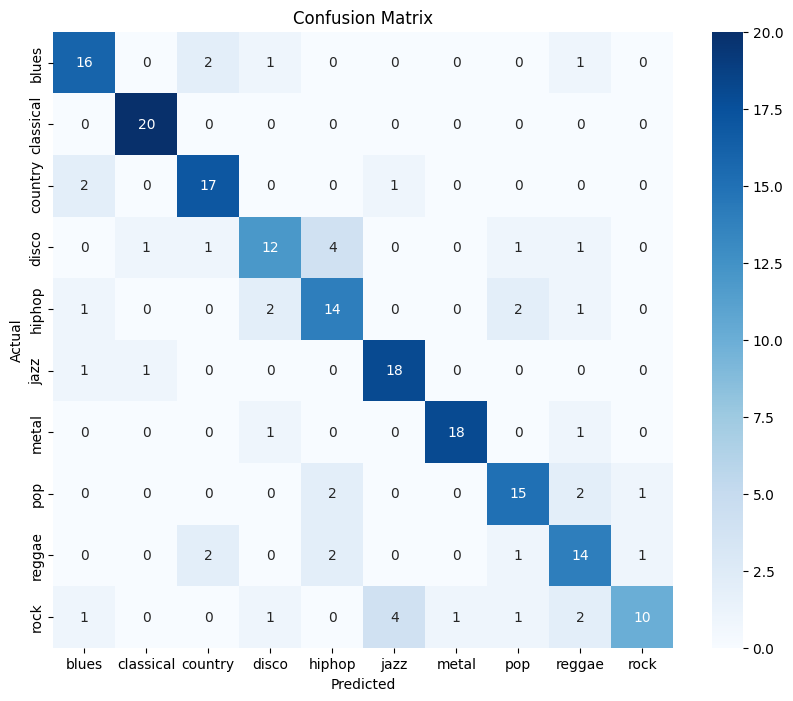

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from matplotlib import pyplot as plt

X_test_segments = df_test_segments[best_features]
y_test_segments = df_test_segments['label']

df_test_segments['predicted_label'] = rf.predict(X_test_segments)

df_test_segments['song'] = df_test_segments['filename'].str.extract(r'(.*\.\d{5})')[0] + '.wav'
song_predictions = df_test_segments.groupby('song')['predicted_label'].apply(majority_vote)

song_true_labels = X_test_songs.set_index('filename').loc[song_predictions.index, 'label']

print("Accuracy Score:")
print(accuracy_score(song_true_labels, song_predictions))

cm = confusion_matrix(song_true_labels, song_predictions, labels=song_true_labels.unique())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=song_true_labels.unique(), yticklabels=song_true_labels.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
